In [1]:
import numpy as np
import scipy as sp
from numpy import linalg as LA
import seaborn as sns
from scipy.optimize import minimize
from scipy.sparse.linalg import eigs
np.random.seed(42)


In [2]:
def ERO(r, eta, p):
    n = r.shape[0]
    r = r.reshape(n, 1)
    M = np.max(np.abs(r))
    e = np.ones((n, 1))
    H_star = eta * p * (r.dot(e.T) - e.dot(r.T))
    H = r.dot(e.T) - e.dot(r.T)
    # Generate all random indicators at once
    indicators = np.triu(np.random.choice(3, (n, n), p=[eta*p, p*(1-eta), 1-p]),1)
    # Generate random values for the second case
    Z = np.random.uniform(-M, M, (n, n))
    H[indicators == 2] = 0
    H[indicators == 1] = Z[indicators == 1]
    H = np.triu(H, 1) - np.triu(H, 1).T
    delta = H - H_star
    return H, delta

def circular_shift(x, shift):
    return np.concatenate((x[-shift:], x[:-shift]))

# def cyclic_perm(x,shift):
#     # n = len(a)
#     b = [[x[i - j] for i in range(shift)] for j in range(shift)]
#     return b


def outer_product(x, y):
    return np.outer(x, y)

def hadamard_product(x, y):
    return x * y

def upset(s, C, shift):
    # print(ones)
    sigma_s = circular_shift(s, shift)
    n = len(s)
    sigma_s = sigma_s.reshape(n,1)
    sigma_outer_ones_T = outer_product(sigma_s, np.ones(len(sigma_s)))
    ones_outer_sigma_T = outer_product(np.ones(len(sigma_s)), sigma_s.T)
    print(np.ones(len(sigma_s)).shape, sigma_s.T.shape)
    term1 = sigma_outer_ones_T - ones_outer_sigma_T
    # print([C != 0])
    # print(hadamard_product(term1, [C!=0]))
    # result = hadamard_product(term1, A)
    result = hadamard_product(term1, [C!=0])
    # P = (sigma_s @ ones.T - ones @ sigma_s.T) * [C!=0]
    # print(P)    P and result are the same --  above calculation should be correct
    print(np.sign(result) - np.sign(C))
    print(np.sum(np.sign(result) - np.sign(C)))
    return 0.5 * (np.sum( np.abs(np.sign(result) - np.sign(C))))
    # return 0.5 * np.max(np.sum(np.sign(result) - np.sign(C),axis = 0))
    # return np.max(np.sum(np.abs(P - C),axis = 0))

    ## ALternative error 
    # print(result - C)
    # print(np.sum(result - C))
    # return np.sum(result - C)


def syncrank(C,g, type):
    n = C.shape[0]
    Theta = 2 * np.pi * g * C / (n-1)
    # print(Theta)
    H = np.exp(1j * Theta)
    if type == 'spectral':
        d = np.sum(np.abs(H),axis = 1) + 1e-10
        ##  d200‘200’ -- array
        ##  ERO model -- all nodes have edges, thus degree = shape[0]
        v,psi = eigs(1j * np.diag(d**(-1)) @ H,1,which = 'LR')
        # v,psi = eigs(1j * np.diag(H**(-1)) @ H,1,which = 'LR')
        xi = np.abs(v)[0]
        # print(v,xi)
        r_hat =  psi / np.abs(psi)
        r_hat = r_hat.reshape(n)
        psi = psi.reshape(n)
        display(psi)
        angles_radians = np.angle(psi)
        display(angles_radians)
        angle_hat = np.angle(r_hat)
        angles_modulo_2pi = np.mod(angles_radians, 2 * np.pi)
        angles_degrees = np.degrees(angles_modulo_2pi)

        # return angle
        # angle[angle < 0] += 2 * np.pi
        # angle_hat[angle_hat < 0] += 2 * np.pi
        # s = np.argsort(angle) # (n,)
        print('angle_degrees is ',angles_degrees)
        sorted_indices = np.argsort(angles_degrees)
        print('label of degree from smallest to largest',sorted_indices)
        # s = pd.Series(angle_hat.tolist()).rank()
        # s = np.array(s).reshape(n)
        # print(s)
        obj = 9999999999999
        best_shift = 0
        for shift in range(n):
            obj1 = upset(sorted_indices,C,shift)
            print(obj1)
            if obj1 < obj:
                obj = obj1
                best_shift = shift
                # print(circular_shift(s,best_shift))
        return circular_shift(sorted_indices,best_shift)


In [3]:
n = np.arange(100)+1
eta, p = 0.8,0.5
H,delta = ERO(n,eta, p)
H

array([[  0.        ,   0.        ,   0.        , ...,  44.16326329,
        -98.        , -99.        ],
       [  0.        ,   0.        ,  -1.        , ...,   0.        ,
          0.        ,   0.        ],
       [  0.        ,   1.        ,   0.        , ..., -95.        ,
          0.        , -97.        ],
       ...,
       [-44.16326329,   0.        ,  95.        , ...,   0.        ,
         72.45850591,   0.        ],
       [ 98.        ,   0.        ,   0.        , ..., -72.45850591,
          0.        ,  -1.        ],
       [ 99.        ,   0.        ,  97.        , ...,   0.        ,
          1.        ,   0.        ]])

In [4]:
x = syncrank(H,0.5,'spectral')
x

array([-1.21758016e-01-0.01172431j, -1.27628557e-01+0.03320182j,
       -1.47950128e-01-0.0233924j , -1.42578422e-01+0.03031657j,
       -1.56217036e-01+0.00658815j, -1.04694135e-01-0.13841151j,
       -1.01680537e-01-0.09239122j, -1.57512492e-01+0.00574744j,
       -7.96586506e-02-0.10093533j, -9.44600541e-02-0.07069826j,
       -1.17743060e-01-0.06621743j, -1.14541651e-01-0.00545508j,
       -7.21449793e-02-0.09071239j, -1.07613435e-01-0.03654535j,
       -6.12777531e-02-0.03256829j, -1.07178300e-01-0.05132285j,
       -1.22556727e-01-0.05095891j, -1.37111017e-01-0.0550634j ,
       -9.45800714e-02-0.04323479j, -1.04130096e-01-0.12213489j,
       -1.06934300e-01-0.01671065j, -9.25073613e-02-0.02526451j,
       -3.44440890e-02-0.12356166j, -6.70254400e-02-0.03399813j,
       -9.11682910e-02-0.01561012j, -5.17128343e-02-0.01484986j,
       -7.36282103e-02-0.05922305j, -6.18585451e-02+0.00292518j,
       -7.27336146e-02-0.05335381j, -4.76083250e-02-0.04903316j,
       -3.57684421e-02-0.

array([-3.04559674,  2.88708959, -2.9847807 ,  2.93208207,  3.09944456,
       -2.21837934, -2.40402333,  3.10512008, -2.23892011, -2.49908681,
       -2.62928735, -3.09400333, -2.24267438, -2.81421415, -2.65307436,
       -2.69500382, -2.74754148, -2.75971014, -2.71283048, -2.27678786,
       -2.98657618, -2.87498615, -1.84265511, -2.67216807, -2.97201392,
       -2.86195687, -2.46420322,  3.09433965, -2.50870233, -2.34145203,
       -2.27484805, -2.2304141 , -2.88030042, -2.16745658, -2.5500267 ,
       -2.82278718, -1.75156917, -2.46778736,  2.9052759 , -0.97055066,
       -0.82686045, -2.83142635, -1.02577186, -1.70562414, -2.73624341,
        1.720882  , -0.42257463, -0.77387489, -0.78590405,  2.17042177,
       -0.9291796 , -3.01717534, -0.24503257, -2.97545707,  1.5806373 ,
        1.5788959 ,  1.27047912,  1.14544765, -1.46512923,  2.46666107,
       -0.0973991 ,  1.24643425,  0.85166524,  1.33017509,  0.4250264 ,
        0.77451906,  0.86040334,  0.93486599,  0.14088317,  0.80

angle_degrees is  [185.50016062 165.41804861 188.98466287 167.99592791 177.58509202
 232.89622661 222.25960921 177.91027533 231.71932704 216.81287337
 209.35293192 182.72666762 231.50422309 198.75740641 207.99003617
 205.5876552  202.57746938 201.88025641 204.56626301 229.54966462
 188.88178987 195.27542764 254.42363916 206.89604761 189.71614601
 196.02195005 218.81155583 177.29260243 216.26194458 225.84468091
 229.66080748 232.20668574 194.9709422  235.81388556 213.89423265
 198.26620821 259.64247922 218.60619957 166.46004761 304.39154313
 312.62438573 197.77122032 301.22760153 262.27493538 203.22480095
  98.59927591 335.78825719 315.66023481 314.97101481 124.35600713
 306.76193077 187.12858685 345.96066804 189.51886782  90.56384596
  90.46407133  72.79309145  65.62931581 276.05427879 141.32926853
 354.41944241  71.41542209  48.79682401  76.21341862  24.35221894
  44.37667335  49.29748034  53.56387555   8.07201084  46.3474502
  39.38775348 107.69029604  82.3895392   87.12258718  91.78

array([49, 59,  1, 38,  3, 27,  4,  7, 11,  0, 51, 20,  2, 53, 24, 32, 21,
       25, 41, 35, 13, 17, 16, 44, 18, 15, 23, 14, 10, 34, 28,  9, 37, 26,
        6, 29, 19, 30, 12,  8, 31,  5, 33, 22, 36, 43, 58, 42, 39, 50, 40,
       48, 47, 46, 52, 60, 68, 64, 70, 80, 65, 69, 62, 66, 90, 76, 67, 87,
       97, 57, 61, 56, 94, 82, 63, 81, 75, 84, 85, 93, 72, 83, 73, 55, 54,
       74, 77, 78, 88, 99, 45, 89, 95, 86, 98, 92, 71, 91, 96, 79])

<Axes: >

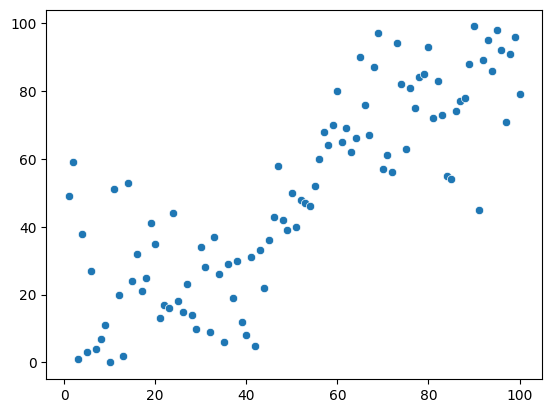

In [5]:
sns.scatterplot(x = np.arange(100)+1, y = x)

<Axes: >

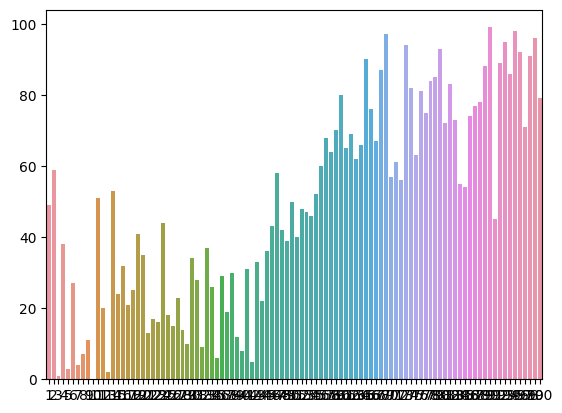

In [6]:
sns.barplot(x = np.arange(100)+1, y = x)